# Squared Loss Diversity Experiments - Varying Ensemble Size

This notebook produces Figure 7, as well as Figure 21 from the appendix of https://arxiv.org/abs/2301.03962v1.


## Comparing Bagging and Random Forests

In [2]:
## Necessary imports and checks
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import  BaggingRegressor, RandomForestRegressor
from decompose.data_utils import load_standard_dataset
from decompose import BVDExperiment
from decompose.plotting_utils import plot_bvd

# Make sure imagees and data directories exist for results/plots
if not os.path.exists("images"):
    os.mkdir("images")
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("logs"):
    os.mkdir("logs")



### Setting Up Variables

In [3]:
# Setting up data
np.random.seed(0)
DATASET_NAME = "california"
train_data, train_labels, test_data, test_labels = load_standard_dataset(DATASET_NAME, 0.5,
                                                                         normalize_data=True)
N_TRIALS = 100

# Setting up models
results_objects = {}

# We use 3 kinds of ensembles: Bagging with depth 8 trees, Bagging with unconstrained trees and Random Forests
constrained_bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),
                                       warm_start=True)
unconstrained_bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                                         warm_start=True)
random_forest = RandomForestRegressor(max_features='sqrt',
                                      warm_start=True)

models = {"Bagging (max depth 8)": constrained_bagging,
          "Bagging (unconstrained)": unconstrained_bagging,
          "Random Forest": random_forest }

### Training the Models

In [3]:
for name, model in models.items():
    np.random.seed(0)
    # Create experiment object and define parameter to vary
    experiment = BVDExperiment(model,
                               "squared",
                               parameter_name="n_estimators",
                               parameter_values=range(1,31,1),
                               )
    # Run experiment on data
    results = experiment.run_experiment(train_data, train_labels, test_data, test_labels, n_trials=N_TRIALS, n_test_splits=1)
    results_objects[name] = results
    results.save_results(f"data/squared_decomp_{name}_{DATASET_NAME}_results_{N_TRIALS}.pkl")

100%|██████████| 30/30 [10:19<00:00, 20.65s/it]


In [4]:
# We also a train a single tree model in order to get the test error
decision_tree = DecisionTreeRegressor(max_depth=8)
np.random.seed(0)
# Create experiment object and define parameter to vary
experiment = BVDExperiment(decision_tree,
                           loss="squared")

# Run experiment on data
one_tree_results = experiment.run_experiment(train_data, train_labels, test_data, test_labels, n_trials=N_TRIALS, n_test_splits=1)
one_tree_results.save_results(f"data/squared_decomp_decision_tree_{DATASET_NAME}_results_{N_TRIALS}.pkl")



## Plotting Results

### Figure 7: Breakdown of Expected Risk into Bias, Variance and Diversity in Bagged Regression Trees

In [5]:
from decompose.experiments import load_results


# load results objects into dictionary where key is model name
results_objects = {}
for name in models:
    results_objects[name] = load_results(f"data/squared_decomp_{name}_{DATASET_NAME}_results_{N_TRIALS}.pkl")
    

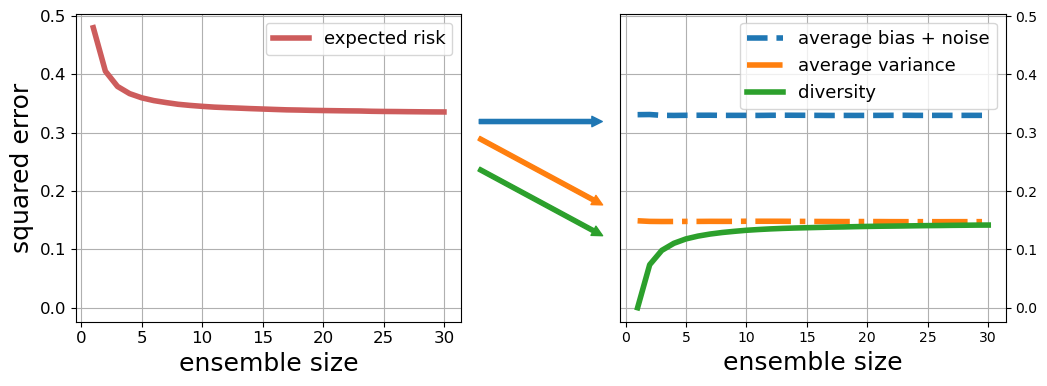

In [6]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4), gridspec_kw={"width_ratios": [3, 1, 3]})


plt.subplots_adjust(wspace=0.05, hspace=0)


arrow = mpatches.FancyArrowPatch((0.0, 0.65),(1.0, 0.65), # ((x tail, y tail), (x head, y head))
                                 mutation_scale=15,
                                 transform=axes[1].transAxes, color="tab:blue")
arrow2 = mpatches.FancyArrowPatch((0.0, 0.6), (1.0, 0.375), # ((x tail, y tail), (x head, y head))
                                 mutation_scale=15,
                                 transform=axes[1].transAxes,
                                 color="tab:orange")
arrow3 = mpatches.FancyArrowPatch((0.0, 0.5),(1.0, 0.275),  # ((x tail, y tail), (x head, y head))
                                 mutation_scale=15,
                                 transform=axes[1].transAxes,
                                 color="tab:green")

axes[1].axis("off")
axes[1].add_patch(arrow)
axes[1].add_patch(arrow2)
axes[1].add_patch(arrow3)
plot_bvd(results_objects["Bagging (max depth 8)"], bias=False, variance=False, diversity=False, axes=axes[0])
plot_bvd(results_objects["Bagging (max depth 8)"], ensemble_risk=False, axes=axes[2])
axes[0].set_xlabel("ensemble size", size=18)
axes[2].set_xlabel("ensemble size", size=18)
axes[2].yaxis.tick_right()
axes[2].legend(prop={"size":13})
axes[0].legend(prop={"size":13})
axes[0].tick_params(axis="both", labelsize= 12)
#axes[2].yaxis.set_label_position("right")
axes[2].tick_params(labelleft=False, labelright=True)
axes[0].set_ylabel("squared error", size=18)

FIGURE_NAME = f"images/error_and_bv_{DATASET_NAME}_{N_TRIALS}.pdf"
plt.savefig(FIGURE_NAME, bbox_inches="tight")

## Code for Generating Figures in Appendix

Bagging (max depth 8) test set risk: [0.33549351]
Bagging (unconstrained) test set risk: [0.27697186]
Random Forest test set risk: [0.2687515]


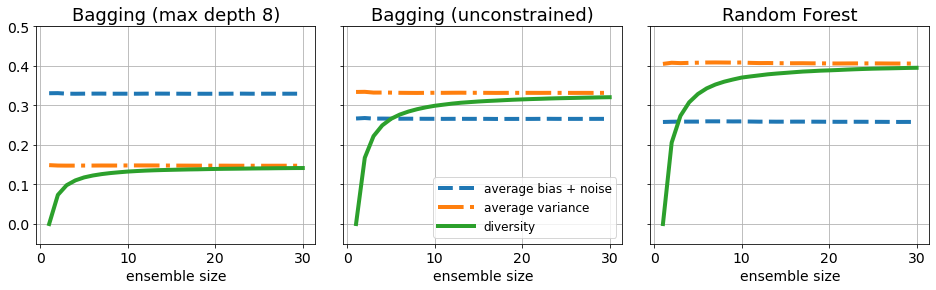

In [4]:
from decompose.experiments import load_results

results_object = {}
for name in models:
    # results_objects[name] = load_results(f"data/Fig4 {name} {DATASET_NAME} results {N_TRIALS}.pkl")
    results_objects[name] = load_results(f"data/squared_decomp_{name}_{DATASET_NAME}_results_{N_TRIALS}.pkl")

import matplotlib

matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(16, 4))

mylinewidth = 3
myylim = [-0.05, 0.5]

# print(f"Single Tree test set risk {one_tree_results.ensemble_risk[-1]}")

for idx, (name, results) in enumerate(results_objects.items()):
    risk = results.ensemble_risk[:, 0]
    avbias = results.average_bias[:, 0]
    avvar = results.average_variance[:, 0]
    diversity = results.diversity[:, 0]

    ax = axes[idx]
    ax.set_ylim(myylim)
    ax.set_title(name, fontsize=18)

    plot_bvd(results, ensemble_risk=False, axes=ax, show_legend=False, x_label=None)
    #ax.plot(avbias, linewidth=mylinewidth, linestyle='--', label="Average Bias + Noise" )
    #ax.plot(avvar, linewidth=mylinewidth, linestyle=':', label="Average Variance"  )
    #ax.plot(diversity, linewidth=mylinewidth, linestyle='-', label="Diversity"  )
    ax.set_yticks([.0, .1, .2, .3, .4, .5])
    ax.set_xlabel("ensemble size", fontsize=14)

    ax.grid(True)

    print(f"{name} test set risk: {results.ensemble_risk[-1]}")

axes[1].legend(fontsize='large', handlelength=3)

fig.subplots_adjust(wspace=0.1, hspace=0)
FIGURE_NAME = f"images/decomp_comparison_rf_bagging_{DATASET_NAME}_{N_TRIALS}_v2.pdf"
plt.savefig(FIGURE_NAME, bbox_inches="tight")
plt.show()